# Perceptive Automata Research Coding Challenge 2021

## Introduction

Hi, there! 

This is the Research Coding Challenge for the Data Scientist position at Perceptive Automata. This challenge focuses primarily on data science and machine learning. We've tried to minimize the amount of imports, but these are all fairly standard packages. If you find yourself spending lots of time installing things before you can even start, shoot me an email as that is not the point of this challenge, and I'll try to help you get up and coding faster as best I can.

There are instructions throughout that should help guide you through the challenge.  You should be able to run all of the code on your machine, without any long runtimes. Also, if you find any errors or typos please be sure to email me at till@perceptiveautomata.com. 

This should be inherently clear, but its worth reiterating: **all work should be your own!**  Please make sure your code is clear and commented so we understand what you did, and when you send the challenge back, include a brief description of your approach.

We're excited to see what you come up with!  

### Imports

In [1]:
import ast
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Older version of sklearn
# from sklearn.cross_validation import train_test_split

# Newer versions of sklearn
from sklearn.model_selection import train_test_split

# Pedestrian Crossing Prediction

In this problem we use the opensource JAAD dataset, which you can read more about here: http://data.nvision2.eecs.yorku.ca/JAAD_dataset/ if you are interested.

The dataset consists of tracked people in some videos from a car's dashcam.  Each of these people have been carefully annotated with a bunch of different attributes, such as whether or not they are stopped or moving fast or moving slow.  For this problem we will try to predict whether or not the pedestrian will cross the street in the next frame based on all previous data we have about the pedestrian.  You will use the bounding boxes of the pedestrians along with the other actions that they take to try to predict this for a test set.

## Dataframe

Each row of the dataframe that we construct for you consists of some meta data about the video id and the ped id so that you can match them up with the JAAD videos, and then an ordered list of frames where that pedestrian appears.  

* frame_numbers - These should be continuous and there should be no gaps in these lists.  The other fields all align with the frame number field.
* bounding_boxes - This field is a series of boxes that aligns with the frame_numbers field.  Each box is constructed of [box x, box y, box width, box height], where x and y represent the upper left hand corner of the box
* moving_slow, stopped, handwave, look, clear path, moving fast, looking, standing, slow down, nod, speed up - The annotated attributes you will use to train the model, each is a list that aligns with the frame_numbers field of whether or not the attribute is true for that frame number
* crossing - This is the field that you will try to predict, whether or not the pedestrian is crossing for this corresponding frame number 
* cross_overall - Whether or the person crossed at any point in the sequence

In [3]:
pedestrians_df = pd.read_csv('pedestrian_df.csv')
for col_name in ['bounding_boxes', 'frame_numbers', 'moving slow', 'stopped', 'handwave', 'look', 'clear path', 'crossing', 'moving fast', 'looking', 'standing', 'slow down', 'nod', 'speed up']:
    pedestrians_df[col_name] = pedestrians_df[col_name].apply(ast.literal_eval)
pedestrians_df.head()

,video_id,ped_ind,frame_numbers,bounding_boxes,moving slow,stopped,handwave,look,clear path,crossing,moving fast,looking,standing,slow down,nod,speed up,cross_overall
0,video_0071,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[1209, 598, 51, 191], [1214, 598, 52, 192], [...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",False
1,video_0071,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[1249, 621, 51, 127], [1254, 620, 51, 129], [...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",True
2,video_0204,1,"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[[1135, 673, 28, 97], [1139, 672, 29, 92], [11...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",True
3,video_0204,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[906, 670, 35, 65], [906, 672, 32, 65], [907,...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",True
4,video_0204,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[1152, 657, 42, 114], [1158, 657, 42, 117], [...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",False


In [4]:
count = 0
for i, row in pedestrians_df.iterrows():
    count += len(row['frame_numbers'])
    
print("Number of Pedestrian-Frames: %d" % count)

Number of Pedestrian-Frames: 128220


In [5]:
# Let's take a more in-depth look at that first row:
print(pedestrians_df.iloc[0])
print(pedestrians_df.iloc[0]['frame_numbers'])

video_id                                                 video_0071
ped_ind                                                           1
frame_numbers     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
bounding_boxes    [[1209, 598, 51, 191], [1214, 598, 52, 192], [...
moving slow       [False, False, False, False, False, False, Fal...
stopped           [True, True, True, True, True, True, True, Tru...
handwave          [False, False, False, False, False, False, Fal...
look              [False, False, False, False, False, False, Fal...
clear path        [False, False, False, False, False, False, Fal...
crossing          [False, False, False, False, False, False, Fal...
moving fast       [False, False, False, False, False, False, Fal...
looking           [False, False, False, False, False, False, Fal...
standing          [False, False, False, False, False, False, Fal...
slow down         [False, False, False, False, False, False, Fal...
nod               [False, False, False, False, F

# More info

Your task is predict, for each pedestrian, whether or not they will be crossing the road at each frame.  For example, for row 0 of the above dataframe, the pedestrian appears in frames 0-329.  For each of those frames, you need to predict whether or not they will be crossing or not crossing in the next frame.  So, for frame number 5, you can use whatever data you want from frames 0-4 to predict whether or not they will be crossing in frame 5.  And for frame 329, you can use whatever data you want from frames 0-328 to predict whether or not they will be crossing in frame 329.

You can skip the first few frames for each pedestrian if your solution requires a certain number of frames to be initialized.

You will need to:
- explore the dataset
- redefine the problem and select an appropriate metric
- unravel the existing per-pedestrian dataframe to build your new per-pedestrian-frame dataframe.  
- extract features
- split the data into train and validation sets (70%-30% split is probably about the right size)
- build a baseline that simply predicts the previous frames' "crossing" value for the next frame
- make some models
- test your final model on your validation set
- write up your analysis

## Solution (Sushmit Roy)

In [6]:
import pandas as pd
import numpy as np
import watermark
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix,precision_recall_fscore_support,roc_curve,roc_auc_score,roc_curve,precision_recall_curve,auc
import torch
from torchvision import transforms
from torch import nn
from torch.utils import data
import time
from torch.utils.data import DataLoader, TensorDataset
plt.style.use('fivethirtyeight')
%matplotlib inline
def plot_fn(Y_test, Y_test_pred):
    '''
    function to plot confusion matrix and roc curve
    Y_test: Actual values
    Y_test_pred: predicted values
    '''
    fig, axs = plt.subplots(1,2,figsize=(20,8))
    cf_matrix = confusion_matrix(Y_test, Y_test_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',ax=axs[0])
    axs[0].set_xlabel('Predicted labels');axs[0].set_ylabel('True labels'); 

    classifier_fpr, classifier_tpr, _ = roc_curve(Y_test, Y_test_pred)
    sns.lineplot(x=classifier_fpr,y=classifier_tpr,ax=axs[1] )
    axs[1].set_xlabel('TPR');axs[0].set_ylabel('FPR'); 
    plt.show()


### EDA

In [7]:
feature_columns = ['moving slow','stopped','handwave','look','clear path',
                   'moving fast','looking','standing','slow down','nod','speed up']
print('Total Number of features', len(feature_columns))

Total Number of features 11


In [8]:

print('Total number of rows ', pedestrians_df.shape[0])
pedestrians_df.head(n=4)

Total number of rows  666


,video_id,ped_ind,frame_numbers,bounding_boxes,moving slow,stopped,handwave,look,clear path,crossing,moving fast,looking,standing,slow down,nod,speed up,cross_overall
0,video_0071,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[1209, 598, 51, 191], [1214, 598, 52, 192], [...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",False
1,video_0071,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[1249, 621, 51, 127], [1254, 620, 51, 129], [...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",True
2,video_0204,1,"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[[1135, 673, 28, 97], [1139, 672, 29, 92], [11...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",True
3,video_0204,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[906, 670, 35, 65], [906, 672, 32, 65], [907,...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",True


In [9]:
print('Check combination of video_id and ped_ind is unique Pass')
assert np.sum(pedestrians_df.duplicated(subset= ['video_id','ped_ind'],keep = False)) == 0

Check combination of video_id and ped_ind is unique Pass


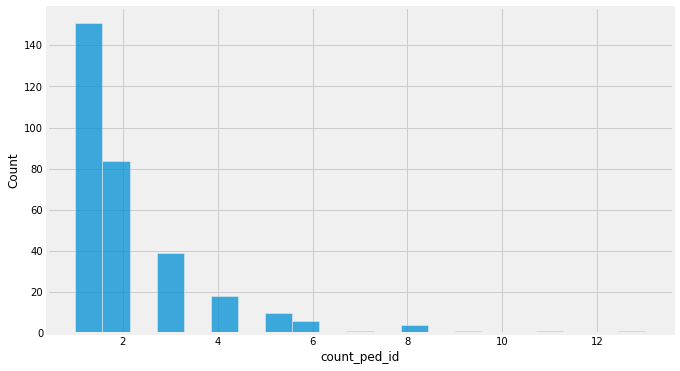

'Statistics for count of ped_id '

count    316.000000
mean       2.107595
std        1.656485
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       13.000000
Name: count_ped_id, dtype: float64

In [10]:
df_group_by_video_id = pedestrians_df.groupby(by = ['video_id']).agg(count_ped_id=('ped_ind', 'count')).reset_index()
fig,axs = plt.subplots(1,1, figsize = (10,6))
sns.histplot(data = df_group_by_video_id, x ="count_ped_id",ax= axs)
plt.show()
display('Statistics for count of ped_id ', df_group_by_video_id.count_ped_id.describe())

In [11]:
df_unstacked_data = pedestrians_df.set_index(['video_id','ped_ind','cross_overall']).apply(pd.Series.explode).reset_index()

print('Check number of rows = 128220 Pass')
assert df_unstacked_data.shape[0] == 128220
df_unstacked_data.head(n=2)

Check number of rows = 128220 Pass


,video_id,ped_ind,cross_overall,frame_numbers,bounding_boxes,moving slow,stopped,handwave,look,clear path,crossing,moving fast,looking,standing,slow down,nod,speed up
0,video_0071,1,False,0,"[1209, 598, 51, 191]",False,True,False,False,False,False,False,False,False,False,False,False
1,video_0071,1,False,1,"[1214, 598, 52, 192]",False,True,False,False,False,False,False,False,False,False,False,False


Calculate Number of frames per video_id and ped_id


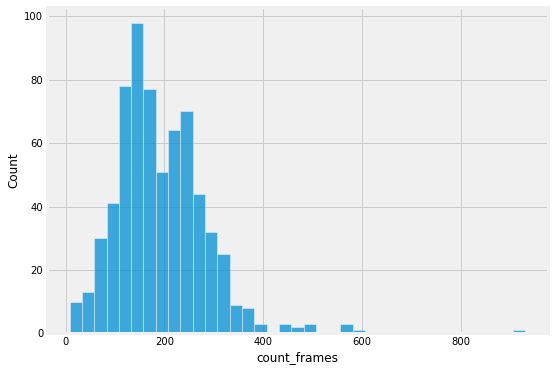

count    666.000000
mean     192.522523
std       92.219468
min        8.000000
25%      131.000000
50%      180.000000
75%      240.000000
max      930.000000
Name: count_frames, dtype: float64

In [12]:
print('Calculate Number of frames per video_id and ped_id')
df_no_of_frames = df_unstacked_data.groupby(by = ['video_id','ped_ind']).agg(
    count_frames=('frame_numbers', 'count'),min_frame_no = ('frame_numbers',min),max_frame_no = ('frame_numbers',max)).reset_index()

fig,axs = plt.subplots(1,1, figsize =(8,6))
sns.histplot(data = df_no_of_frames,x = 'count_frames',ax=axs)
plt.show()
display(df_no_of_frames.count_frames.describe())

In [13]:
print('Check there are np gaps between frames: Pass')
arr1 = df_no_of_frames.count_frames.values
arr2 = (df_no_of_frames.max_frame_no - df_no_of_frames.min_frame_no + 1).values
assert np.sum(arr1 - arr2) == 0

Check there are np gaps between frames: Pass


In [14]:
def return_min_true_index(s):
    '''
    Function to return minimum index of True Value
    Input: List type
    Output: -1 if True is not present else return the minimum index
    '''
    if True in s:
        return s.index(True)
    else:
        return -1

pedestrians_df_to_work = pedestrians_df.copy()
## Add column to get minimum number of frames before we notice crossing
pedestrians_df_to_work['min_frames_before_crossing'] = pedestrians_df_to_work.crossing.apply(return_min_true_index)


In [15]:
print(' Check if cross_overall is True only if atleast one crossing is True : Pass')
_dftemp = pedestrians_df_to_work[(pedestrians_df_to_work.cross_overall == True) & (pedestrians_df_to_work.min_frames_before_crossing == -1)]
assert _dftemp.shape[0] == 0

 Check if cross_overall is True only if atleast one crossing is True : Pass


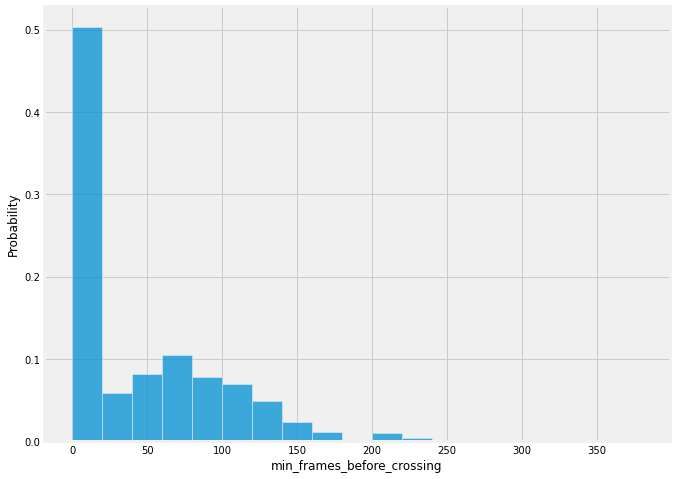

count    515.000000
mean      44.656311
std       55.734539
min        0.000000
25%        0.000000
50%       18.000000
75%       80.500000
max      380.000000
Name: min_frames_before_crossing, dtype: float64

,min_frames_before_crossing
count,282.000000
mean,81.553191
std,51.597391
min,1.000000
25%,46.000000
50%,75.000000
75%,107.750000
max,380.000000


In [16]:
_df_temp_true_crossing = pedestrians_df_to_work[pedestrians_df_to_work.min_frames_before_crossing >=0]

fig,axs = plt.subplots(1,1,figsize = (10,8))
sns.histplot(data = _df_temp_true_crossing,x = 'min_frames_before_crossing',ax = axs,stat='probability')
plt.show()

display(_df_temp_true_crossing.min_frames_before_crossing.describe())

display(_df_temp_true_crossing[_df_temp_true_crossing.min_frames_before_crossing > 0].describe())

In [17]:
print('Number of videos where ped is crossing')
pedestrians_df_to_work.cross_overall.value_counts()

Number of videos where ped is crossing


True     515
False    151
Name: cross_overall, dtype: int64

## Splitting into train Vs test

In [18]:
pedestrians_df_to_work['unique_id'] = pedestrians_df_to_work.video_id + pedestrians_df_to_work.ped_ind
df_unstacked_data['unique_id'] = df_unstacked_data.video_id + df_unstacked_data.ped_ind
## Check uniqueness of unique_id
assert np.sum(pedestrians_df_to_work.unique_id.duplicated()) == 0
## split into test and train with cross_overall as stratify
_train, _test = train_test_split(pedestrians_df_to_work, test_size=0.3, 
                               random_state=0, stratify = pedestrians_df_to_work[['cross_overall']])
train_list = list(_train.unique_id)
test_list = list(_test.unique_id)

## Data Transformation

In [19]:
df_unstacked_data_train = df_unstacked_data[df_unstacked_data.unique_id.isin(train_list)]
df_unstacked_data_test = df_unstacked_data[df_unstacked_data.unique_id.isin(test_list)]

df_unstacked_data_train['next_crossing_value'] =  df_unstacked_data_train.groupby(by=['video_id','ped_ind'])['crossing'].transform(lambda x: x.shift(-1))
df_unstacked_data_test['next_crossing_value'] = df_unstacked_data_test.groupby(by=['video_id','ped_ind'])['crossing'].transform(lambda x: x.shift(-1))
df_unstacked_data_train = df_unstacked_data_train.dropna(subset=['next_crossing_value'])
df_unstacked_data_test = df_unstacked_data_test.dropna(subset=['next_crossing_value'])
feature_columns = ['moving slow','stopped','handwave','look','clear path',
                   'moving fast','looking','standing','slow down','nod','speed up']


X_train = df_unstacked_data_train.loc[:,feature_columns].values.astype(int)
Y_train = df_unstacked_data_train.next_crossing_value.values.astype(int)
X_test = df_unstacked_data_test.loc[:,feature_columns].values.astype(int)
Y_test = df_unstacked_data_test.next_crossing_value.values.astype(int)

<ipython-input-19-735503ac5b9b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unstacked_data_train['next_crossing_value'] =  df_unstacked_data_train.groupby(by=['video_id','ped_ind'])['crossing'].transform(lambda x: x.shift(-1))
<ipython-input-19-735503ac5b9b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unstacked_data_test['next_crossing_value'] = df_unstacked_data_test.groupby(by=['video_id','ped_ind'])['crossing'].transform(lambda x: x.shift(-1))


## Naive Bayes 

In [20]:
clf = BernoulliNB()
clf.fit(X_train, Y_train)

Y_train_pred = clf.predict(X_train)
Y_test_pred = clf.predict(X_test)
print('Train accuracy: ', np.sum(Y_train_pred== Y_train)/Y_train.shape[0])
print('Train Test: ', np.sum(Y_test_pred== Y_test)/Y_test.shape[0])

Train accuracy:  0.9763927918283599
Train Test:  0.9896509847404826


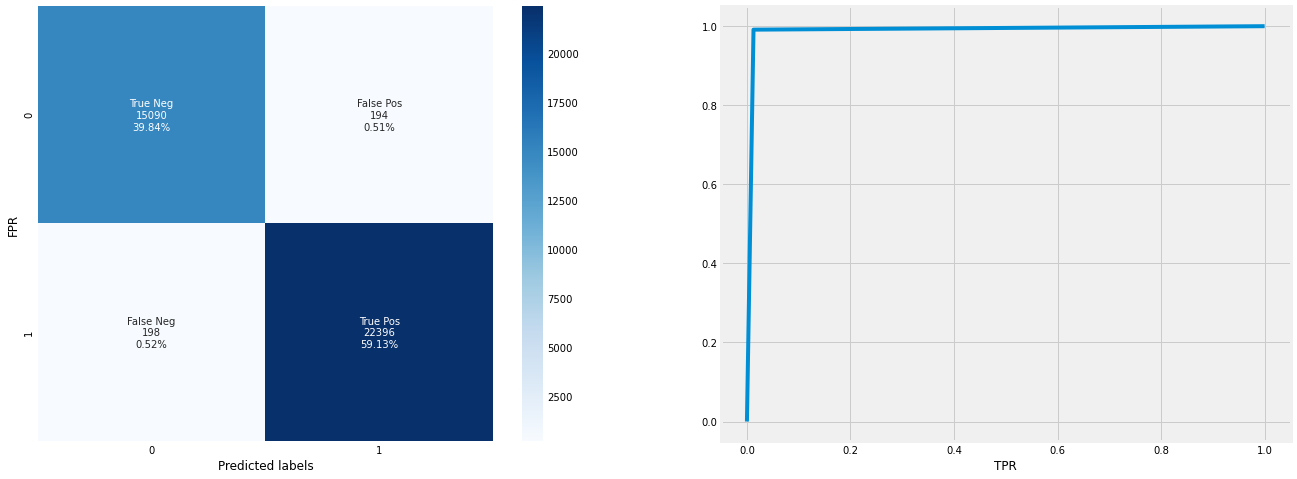

In [21]:
plot_fn(Y_test, Y_test_pred)

## Decision Tree

In [22]:
clf = tree.DecisionTreeClassifier(criterion = "gini",  max_depth = 7)
clf.fit(X_train, Y_train)

Y_train_pred = clf.predict(X_train)
Y_test_pred = clf.predict(X_test)
print('Train accuracy: ', np.sum(Y_train_pred== Y_train)/Y_train.shape[0])
print('Train Test: ', np.sum(Y_test_pred== Y_test)/Y_test.shape[0])

Train accuracy:  0.9775636736696552
Train Test:  0.9900997940757168


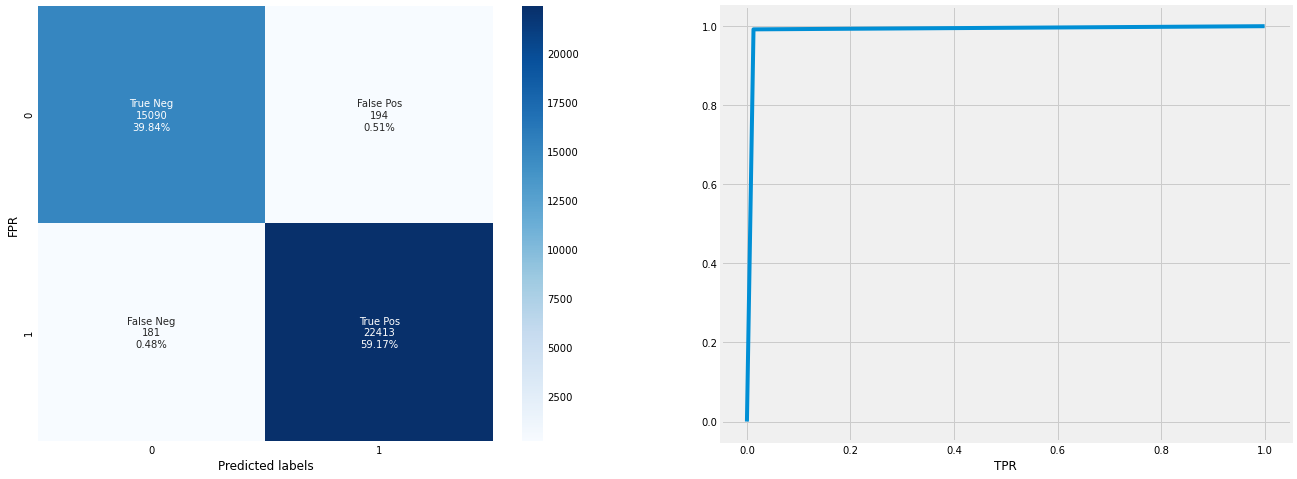

In [23]:
plot_fn(Y_test, Y_test_pred)

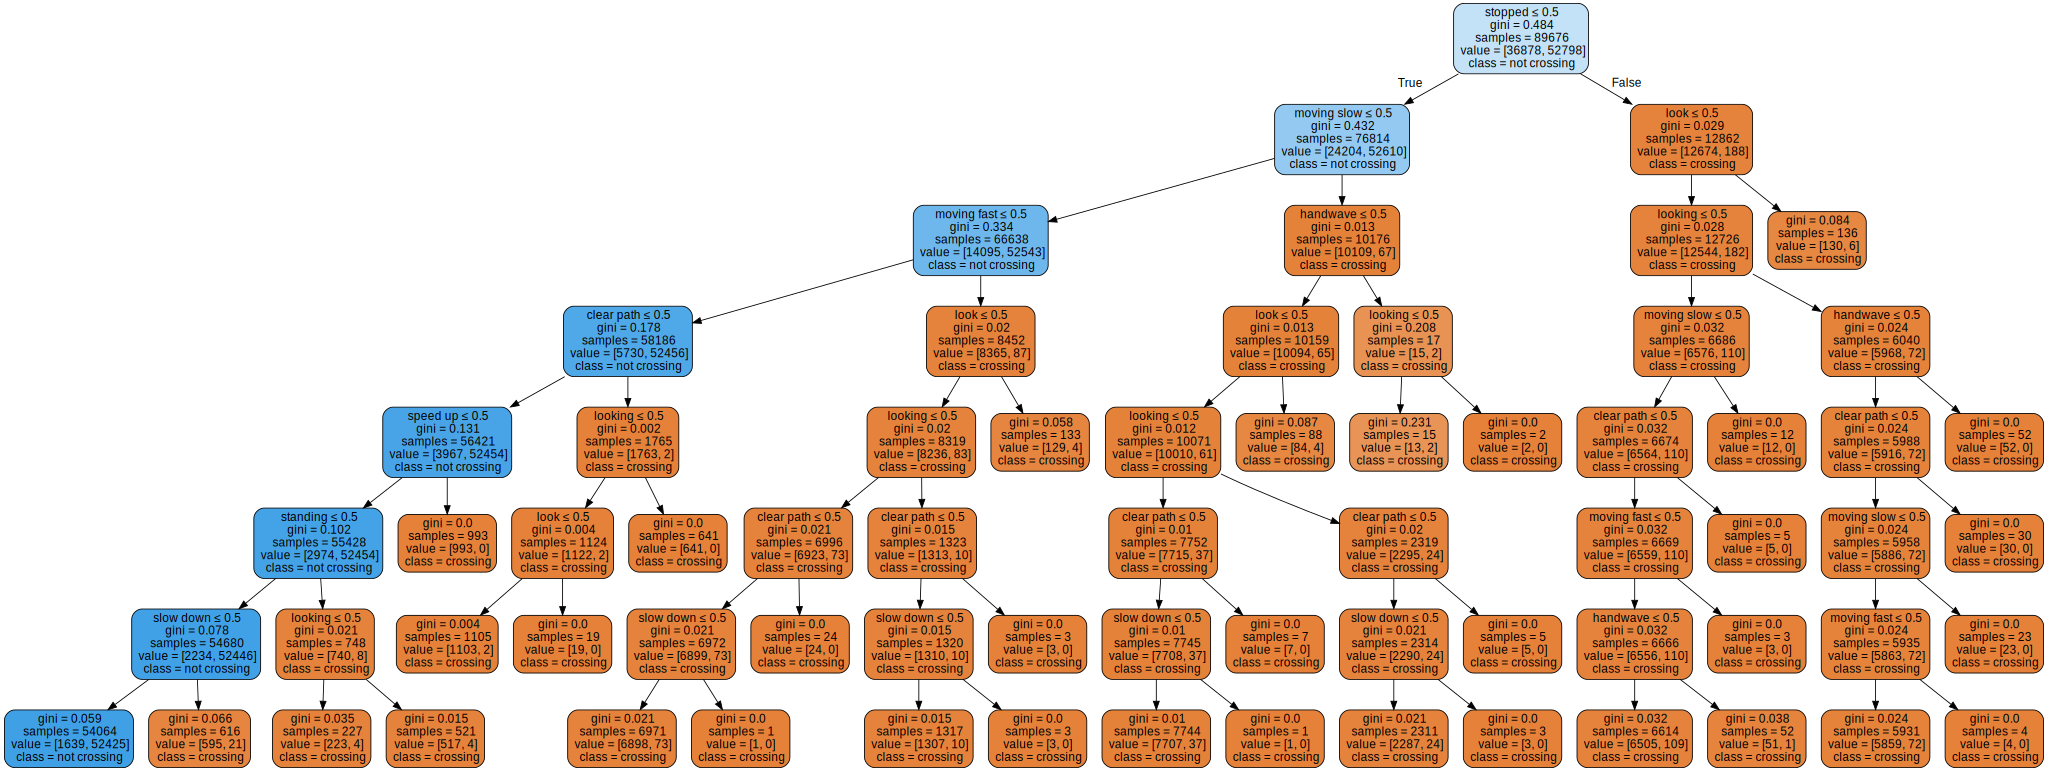

In [24]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=feature_columns,  max_depth=7, 
                     class_names=['crossing','not crossing'],  
                     filled=True, rounded=True,  
                     special_characters=True)
graph = graphviz.Source(dot_data)  
graph

## Model Building using neural network

### Data Transformation

In [25]:
df_unstacked_data_train = df_unstacked_data[df_unstacked_data.unique_id.isin(train_list)]
df_unstacked_data_test = df_unstacked_data[df_unstacked_data.unique_id.isin(test_list)]
def generate_seq(df,tau=7):
    '''
    Function to generate the sequence
    df: Unstacked dataframe
    tau: window size defaults to tau = 7
    '''
    feature_columns = ['moving slow','stopped','handwave','look','clear path',
                               'moving fast','looking','standing','slow down','nod','speed up']
    
    _feature_list = []
    _y_list = []
    for _id in df.unique_id.unique():
        cond = (df.unique_id == _id)
        _df_temp = df[cond].copy()
        n = _df_temp.shape[0]
        total_rows = n - tau 
        features = np.zeros((total_rows, tau,len(feature_columns)))
        y = np.zeros(total_rows)
        for i in range(total_rows):
            features[i] = _df_temp.loc[:,feature_columns].iloc[i:i+tau].values.astype(int)
            y[i] = int(_df_temp.crossing.values[tau+i])
            _feature_list.append(features[i])
            _y_list.append(y[i])
    return np.stack(_feature_list,axis=0),np.stack(_y_list,axis=0)


In [26]:
X_train,Y_train = generate_seq(df_unstacked_data_train)
X_test,Y_test = generate_seq(df_unstacked_data_test)

In [27]:
batch_size = 256
torch_X_train = torch.from_numpy((X_train).astype(np.float32))
torch_Y_train =  torch.from_numpy(Y_train).type(torch.LongTensor)
torch_X_test = torch.from_numpy((X_test).astype(np.float32))

# Pytorch train and test sets
torch_train = TensorDataset(torch_X_train,torch_Y_train)
# data loader
train_iter = DataLoader(torch_train, batch_size = batch_size, shuffle = True)
train_iter_pred = data.DataLoader(torch_X_train,batch_size,shuffle = False, num_workers = 4)
test_iter_pred = data.DataLoader(torch_X_test,batch_size,shuffle = False, num_workers = 4)


## NN model defintion

In [28]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= i+1:
        return torch.cuda.device(f'cuda:{i}')
    else:
        return torch.device('cpu')

class Accumalator:
    """
    Accumalating sums over n variables
    """
    def __init__(self,n):
        self.data = [0.0] * n
    def add(self, *args ):
        self.data = [a+b for a,b in  zip(self.data,args)]
    def reset(self):
        self = [0.0] * len(self.data)
    def __getitem__(self,idx):
        return self.data[idx]

class classification_model():
    def __init__(self,net, device = try_gpu()):
        '''
        net: Pytorch neural network model
        '''
        self.net = net
        self.device = device
    
    def fit(self, optimizer_fn,loss_fn,num_epochs,lr,train_iter,verbose = True):
        '''
        to fit the model
        optimizer_fn: optimizer function
        loss_fn: loss function
        num_epochs: number of epcohs
        lr: learning rate
        train_iter: training iterator Pytorch dataloader
        verbose: Default true prints the loss and accuracy every 10th epoch
        '''
        self.net.apply(self.init_weights)
        print('training on', self.device)
        self.net.to(self.device)
        num_batches = len(train_iter)
        optimizer = optimizer_fn(self.net.parameters(), lr=lr)
        time_array = np.zeros(num_epochs)
        acc_array = np.zeros(num_epochs)
        loss_array = np.zeros(num_epochs)
        for epoch in range(num_epochs):
            start_time = time.time()
            metric = Accumalator(3)
            self.net.train()
            for i,(X, y) in enumerate(train_iter):
                optimizer.zero_grad()
                X, y = X.to(self.device), y.to(self.device)
                y_hat = self.net(X)
                l = loss_fn(y_hat, y)
                l.backward()
                optimizer.step()
                with torch.no_grad():
                    metric.add(l * X.shape[0], self.accuracy(y_hat, y), X.shape[0])
            train_l = metric[0]/metric[2]
            train_acc = metric[1] / metric[2]
            if (epoch%10 == 0 or epoch == (num_epochs - 1)) and verbose:
                print('epoch number', epoch)
                print(f'Training loss {train_l}')
                print(f'Training accuracy {train_acc}')
            end_time = time.time()
            time_array[epoch] = end_time - start_time
            acc_array[epoch] = train_acc
            loss_array[epoch] = train_l
        return (time_array,acc_array,loss_array)
               
    def init_weights(self,m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
            
    def accuracy(self,y_hat,y):
        y_pred = torch.argmax(y_hat,axis=1)
        y_pred = y_pred.type(y.dtype)
        return float(torch.sum(y_pred == y))
    
    def prediction(self,data_iter):
        if isinstance(self.net, torch.nn.Module):
            self.net.eval() 
        for i,_data in enumerate(data_iter):
            if i == 0:
                pred = np.zeros(_data.shape[0])
                pred = torch.argmax(self.net(_data),axis = 1).numpy()
            else:
                pred = np.concatenate((pred,torch.argmax(self.net(_data),axis = 1).numpy()))
        return pred

In [29]:
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 77)
net = torch.nn.Sequential(
    Reshape(),
    nn.Linear(77, 32), nn.Sigmoid(),
    nn.Linear(32, 16), nn.Sigmoid(),
    nn.Linear(16, 2))
loss = nn.CrossEntropyLoss()
model = classification_model(net)
model_results = model.fit(torch.optim.SGD,loss,50,0.9,train_iter)

training on cpu
epoch number 0
Training loss 0.20324327051639557
Training accuracy 0.9188190607734806
epoch number 10
Training loss 0.10379808396100998
Training accuracy 0.977647329650092
epoch number 20
Training loss 0.10335410386323929
Training accuracy 0.9777624309392265
epoch number 30
Training loss 0.10308818519115448
Training accuracy 0.9777969613259668
epoch number 40
Training loss 0.10262776911258698
Training accuracy 0.9778545119705341
epoch number 49
Training loss 0.10250584781169891
Training accuracy 0.9778430018416207


In [30]:
pred_test_values = model.prediction(test_iter_pred)
print('Test Accuracy ',np.sum(pred_test_values == Y_test)/Y_test.shape[0])

Test Accuracy  0.9910573095588636


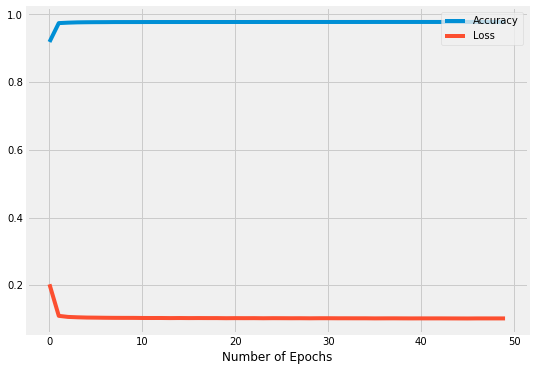

In [31]:
fig,axs = plt.subplots(1,1,figsize = (8,6))
axs.plot(model_results[1],label = 'Accuracy')
axs.plot(model_results[2], label = 'Loss')
axs.set_xlabel('Number of Epochs')
plt.legend(loc="upper right")
plt.show()

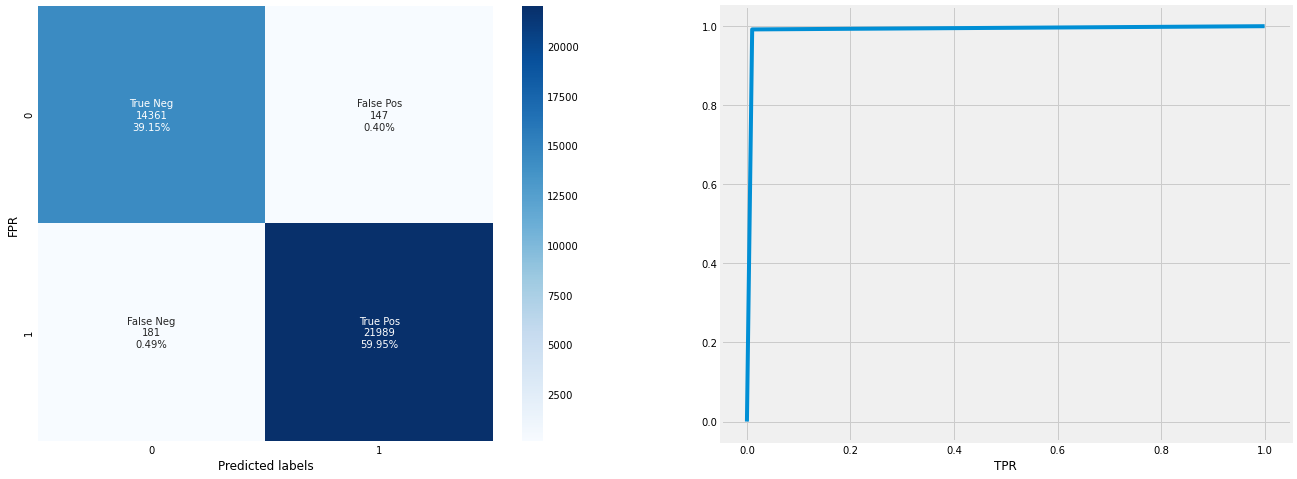

In [32]:
plot_fn(Y_test,pred_test_values)

In [33]:
%load_ext watermark
%watermark -n -u -v -iv -w -a sushmit86@gmail.com

Author: sushmit86@gmail.com

Last updated: Mon Feb 22 2021

Python implementation: CPython
Python version       : 3.8.2
IPython version      : 7.20.0

numpy      : 1.19.2
matplotlib : 3.3.2
seaborn    : 0.11.1
sklearn    : 0.23.2
pandas     : 1.2.1
watermark  : 2.1.0
graphviz   : 0.16
torchvision: 0.8.2
torch      : 1.7.1

Watermark: 2.1.0



# Analysis
## EDA: 
- Total 11 features. 666 rows of data
- Combination of video_id and ped_ind is unique
- Mostly there are 2 ped_id per video_id
- There are few outliers of frames per (video_id and ped_id)
- Minimum number of frames per (video_id and ped_id) is 8. We will use this as a window size when deciding the sequence size for the neural network model
## Test/Train split
- We will use the cross_overall column to stratify
- Create an unique key out of video_id and ped_id
- Split it into 70/30
- Create test and train list
## Predicting the value of nth frame crossing using featutes from n-1 frame
### Data Transformation
- Create a new column ```next_crossing_value```. It will serve as the value to predict
- Discard the last frame. (Remove nan)
### Naive Bayes
```We try a  Bernoulli Naive Bayes classifier as all the features are binary```
- Train accuracy of 97.6%
- Test accuracy of 98.9%
### Decision Tree
```Decision tree helps us to understand features being utilized for node splits```
- Train accuracy of 97%
- Test accuracy of 99%
# Model Building using neural network
```Above models dont capture any features beyond the n -1 frame. We can transform the features to capture information about prior frames```
- Using a window size of 7 we generate sequences of feature and label. 
- For every 7 rows we create a feature vector and the 8th valoe of crossing becomes the label. Refer to generate_seq
### Neural network model (MLP
- Train accuracy of 97.7%
- Test accuracy of 99.10%

*** We could have tried other modelling techniques like LSTM or RNN for solving the problem ***